**Objective of the Lyft Driver Churn Analysis and Retention Strategy Design**

In this project, we analyze historical Lyft driver activity data to identify behavioral patterns that lead to driver churn, segment drivers by risk levels, and design targeted interventions to reduce churn and increase retention-based revenue.</br>

The dataset contains ride-level and driver-level data.

The business challenge is to reduce driver churn, which negatively affects rider wait times, market liquidity, and Lyft's revenue.

**Goals:**

* Define churn in a way that reflects business impact and operational goals
* Apply unsupervised clustering (t-SNE + K-Means) to segment drivers into behavioral groups
* Design segment-specific strategies (e.g., onboarding improvements, bonuses, winback campaigns) to reduce churn
* Estimate business impact of reducing churn by 10%, 15%, and 20% across each cluster
* Formulate hypotheses and outline experiment frameworks (A/B tests) to validate proposed strategies in a real-world setting

This notebook serves as a full case study to bridge data analysis, machine learning, and strategic decision-making for driver retention.

In [ ]:
!pip install -q lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 7.8 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from google.colab import drive
drive.mount('/content/drive')

from google.colab import userdata

Mounted at /content/drive


In [ ]:
df_ride_ids = pd.read_csv(f'{userdata.get("Lyft_path")}ride_ids.csv')
df_ride_timestamps = pd.read_csv(f'{userdata.get("Lyft_path")}ride_timestamps.csv')
df_driver_ids = pd.read_csv(f'{userdata.get("Lyft_path")}driver_ids.csv')

#### **Rides Ids**

In [ ]:
df_ride_ids.head()

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,25
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,100


In [ ]:
df_ride_ids.describe()

,ride_distance,ride_duration,ride_prime_time
count,193502.000000,193502.000000,193502.000000
mean,6955.218266,858.966099,17.305893
std,8929.444606,571.375818,30.825800
min,-2.000000,2.000000,0.000000
25%,2459.000000,491.000000,0.000000
50%,4015.000000,727.000000,0.000000
75%,7193.000000,1069.000000,25.000000
max,724679.000000,28204.000000,500.000000


#### **Rides Timestamps**

In [ ]:
df_ride_timestamps.head()

,ride_id,event,timestamp
0,00003037a262d9ee40e61b5c0718f7f0,requested_at,2016-06-13 09:39:19
1,00003037a262d9ee40e61b5c0718f7f0,accepted_at,2016-06-13 09:39:51
2,00003037a262d9ee40e61b5c0718f7f0,arrived_at,2016-06-13 09:44:31
3,00003037a262d9ee40e61b5c0718f7f0,picked_up_at,2016-06-13 09:44:33
4,00003037a262d9ee40e61b5c0718f7f0,dropped_off_at,2016-06-13 10:03:05


In [ ]:
df_ride_timestamps['event'].value_counts()

,count
event,
requested_at,194081
accepted_at,194081
arrived_at,194081
picked_up_at,194081
dropped_off_at,194081


#### **Drivers Ids**

In [ ]:
df_driver_ids.head()

,driver_id,driver_onboard_date
0,002be0ffdc997bd5c50703158b7c2491,2016-03-29 00:00:00
1,007f0389f9c7b03ef97098422f902e62,2016-03-29 00:00:00
2,011e5c5dfc5c2c92501b8b24d47509bc,2016-04-05 00:00:00
3,0152a2f305e71d26cc964f8d4411add9,2016-04-23 00:00:00
4,01674381af7edd264113d4e6ed55ecda,2016-04-29 00:00:00


In [ ]:
df_driver_ids.describe()

,driver_id,driver_onboard_date
count,937,937
unique,937,49
top,ffff51a71f2f185ec5e97d59dbcd7a78,2016-04-05 00:00:00
freq,1,36


### **Exploratory Data Analysis (EDA) Summary**
**Dataset Shape:**

* ride_ids: *(193502, 5)*
* ride_timestamps: *(970405, 3)*
* driver_ids: *(937, 2)*

**Feature Types:**

* Categorical: *event* (requested_at, accepted_at, arrived_at, picked_up_at, dropped_off_at)
* Continuous: *ride_distance, ride_duration, ride_prime_time*
* Datetime: *timestamp, driver_onboard_date*

**Distribution of Gap Days Between Driver Rides**</br>
We examined the number of days between consecutive rides for each driver to better understand ride frequency and inactivity patterns. The distribution is highly right-skewed, with the vast majority of gaps concentrated in the first few days. Over 90% of all gaps occur within the first 3 days, with a sharp drop-off beyond that point. For example, 1-day gaps account for over 19,000 occurrences, while gaps of 7 or more days become increasingly rare. This suggests that most active drivers return to the platform quickly, and longer gaps—especially beyond a week—may be early indicators of disengagement or churn risk.

**Cumulative Distribution of Gap Days**</br>
The cumulative distribution function (CDF) of gap days reveals that driver activity is highly concentrated within short timeframes. Approximately 75% of all ride gaps are just 1 day, and over 91% occur within 3 days. By the 7-day mark, more than 97.5% of all gaps are accounted for, indicating that the vast majority of drivers return to the platform within a week. After 14 days, over 99% of ride gaps have occurred, with only a small fraction extending beyond 30 days.

**Kaplan–Meier Survival Curves by Driver Activity Level**</br>
To understand how likely drivers are to return to the platform after their last ride, we plotted Kaplan–Meier survival curves segmented by total active days. The two smallest groups—"1–3 days" and "4–7 days"—show flat survival curves for a long period, followed by a sudden drop, which likely reflects sparse data and censoring effects rather than meaningful patterns. For this reason, we consider them unreliable and exclude them from interpretation.

Among the more data-rich segments, "8–14 days" and "15–30 days" show consistent step-wise declines in survival probability. The "8–14 days" group starts at around 0.9 and declines steadily to 0.2 by day 30, indicating gradual disengagement. The "15–30 days" group begins at a lower baseline (around 0.62), suggesting weaker short-term retention, and drops to approximately 0.18 within 15 days — highlighting an even faster churn rate. The "30+ days" group represents historically high-engagement drivers, yet their survival curve drops sharply after just one day of inactivity. This likely reflects a combination of true churn and premature censoring, since many of these drivers may have had their last ride near the end of the dataset. Adjusting the censoring threshold upward for this group could yield a more accurate survival estimate.

These curves highlight how retention behavior differs by driver engagement history and reinforce the need for early, targeted interventions, especially for drivers with intermediate or long engagement histories who are now slipping away.

**Driver Clustering for Churn Identification**</br>
To better understand and identify churn-prone drivers, we applied unsupervised clustering techniques on driver-level behavior features. First, we split the data chronologically to simulate a real-world scenario: the first half of the data was used to generate features, and the second half was used to label churn (i.e., whether a driver returned after the split).

We engineered several aggregate features to describe driver behavior:
* *total_ride_duration*
* *total_ride_prime_time*
* *total_ride_distance*
* *mean_rides_weekly*
* *mean_rides_monthly*

These features were scaled to normalize input for clustering models.

We began with Principal Component Analysis (PCA) to uncover any linear separations between churned and retained drivers. However, PCA failed to produce meaningful separation—indicating that churn behavior likely arises from non-linear relationships between features.

Next, we applied t-SNE, a non-linear dimensionality reduction method, which successfully clustered drivers into four distinct groups based on behavior patterns. Each group showed very different churn rates:
* Cluster 0: 177 drivers — churn rate 42.4%
* Cluster 1: 444 drivers — churn rate 1.1% - highly retained
* Cluster 2: 88 drivers — churn rate 71.6% - high-risk group
* Cluster 3: 133 drivers — churn rate 16.5%

This clustering gives us strong evidence that behavioral patterns correlate with churn probability, even without explicit supervision. We can now use the resulting cluster labels as an input feature in downstream churn prediction models to improve performance and tailor interventions by risk group.

**Simulating Business Impact of Churn Reduction**</br>
To quantify the value of reducing driver churn, we estimated the additional revenue Lyft could generate by retaining a portion of drivers who would otherwise churn. This simulation uses real data-derived assumptions:
* Average monthly rides per retained driver: 13
* Average ride distance: 7,636.7 meters
* Average ride price: $6.90
* Estimated average price per meter: \$0.00091 </br>
(based on \$1.475/mile, derived from a midpoint between \$0.90 and \$2.05/mile)

We applied churn reduction scenarios of 10%, 15%, and 20% across each behavioral cluster (derived from t-SNE). For each scenario, we estimated:
* The number of additional drivers retained *(Δ Retained)*
* The expected additional rides (monthly)
* The resulting revenue lift

**Cluster 0: 177 drivers, churn rate = 42.4% → ~75 churned**

| Churn Reduction | Δ Retained | Extra Rides | Revenue (\$) |
| --------------- | ---------- | ----------- | ------------ |
| 10%             | 7          | 91          | 627.90       |
| 15%             | 11         | 143         | 986.70       |
| 20%             | 15         | 195         | 1,345.50     |

**Cluster 1: 444 drivers, churn rate = 1.1% → ~5 churned**

| Churn Reduction | Δ Retained | Extra Rides | Revenue (\$) |
| --------------- | ---------- | ----------- | ------------ |
| 10%             | 1          | 13          | 89.70        |
| 15%             | 1          | 13          | 89.70        |
| 20%             | 1          | 13          | 89.70        |

Note: Cluster 1 is already highly retained. Churn reduction yields minimal gains and may not justify intervention costs.

**Cluster 2: 88 drivers, churn rate = 71.6% → ~63 churned**

| Churn Reduction | Δ Retained | Extra Rides | Revenue (\$) |
| --------------- | ---------- | ----------- | ------------ |
| 10%             | 6          | 78          | 538.20       |
| 15%             | 9          | 117         | 807.30       |
| 20%             | 13         | 169         | 1,166.10     |

High potential segment. Small reductions in churn could yield meaningful revenue increases.

**Cluster 3: 133 drivers, churn rate = 16.5% → ~22 churned**

| Churn Reduction | Δ Retained | Extra Rides | Revenue (\$) |
| --------------- | ---------- | ----------- | ------------ |
| 10%             | 2          | 26          | 179.40       |
| 15%             | 3          | 39          | 269.10       |
| 20%             | 4          | 52          | 358.80       |




In [ ]:
df_ride_timestamps['timestamp'] = pd.to_datetime(df_ride_timestamps['timestamp'])
df_ride_timestamps['date'] = df_ride_timestamps['timestamp'].dt.date
df_ride_timestamps['date'] = pd.to_datetime(df_ride_timestamps['date'])

df_group_rides_drivers = df_ride_timestamps.merge(df_ride_ids, on='ride_id', how='left').dropna()
df_drivers_dropped_off = df_group_rides_drivers[df_group_rides_drivers['event'] == 'dropped_off_at'].copy()

# Sort the dataframe by driver_id and date to get the real gap_days using diff
df_drivers_dropped_off = df_drivers_dropped_off.sort_values(by=['driver_id', 'date'])

# Get gaps
df_drivers_dropped_off['gap_days'] = df_drivers_dropped_off.groupby('driver_id')['date'].diff().dt.days
df_drivers_dropped_off = df_drivers_dropped_off.dropna()

# I dont care about intraday gaps
df_drivers_dropped_off = df_drivers_dropped_off.drop_duplicates(['date', 'driver_id'])

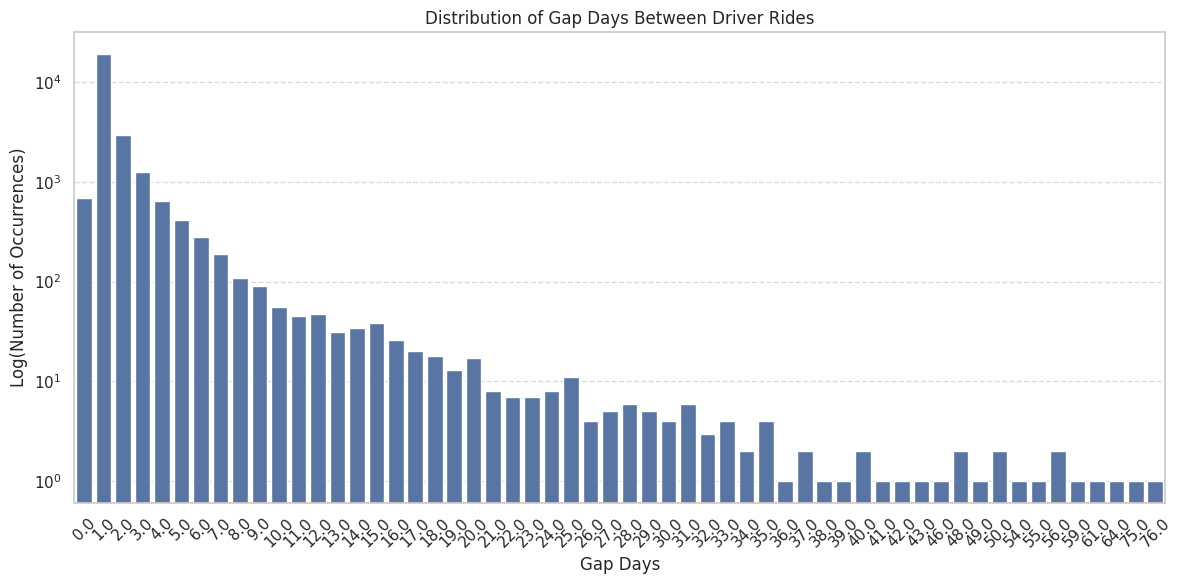

In [ ]:
# Set seaborn style
sns.set(style="whitegrid")
# Get value counts
gap_counts = df_drivers_dropped_off['gap_days'].value_counts().sort_index()

# Plot bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=gap_counts.index, y=gap_counts.values)
plt.yscale("log")
plt.title('Distribution of Gap Days Between Driver Rides')
plt.xlabel('Gap Days')
plt.ylabel('Log(Number of Occurrences)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

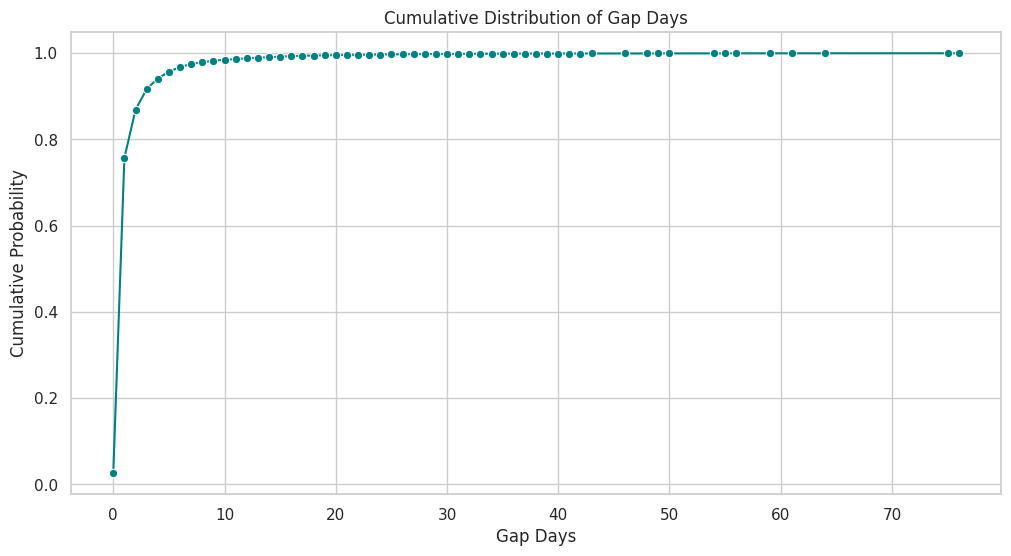

In [ ]:
# Sort values for CDF
cumulative = np.cumsum(gap_counts.values)
cdf = cumulative / cumulative[-1]

plt.figure(figsize=(12, 6))
sns.lineplot(x=gap_counts.index, y=cdf, marker='o', color='teal')
plt.title('Cumulative Distribution of Gap Days')
plt.xlabel('Gap Days')
plt.ylabel('Cumulative Probability')
plt.grid(True)
plt.show()

In [ ]:
df_drivers_dropped_off['date'].max()

Timestamp('2016-06-27 00:00:00')

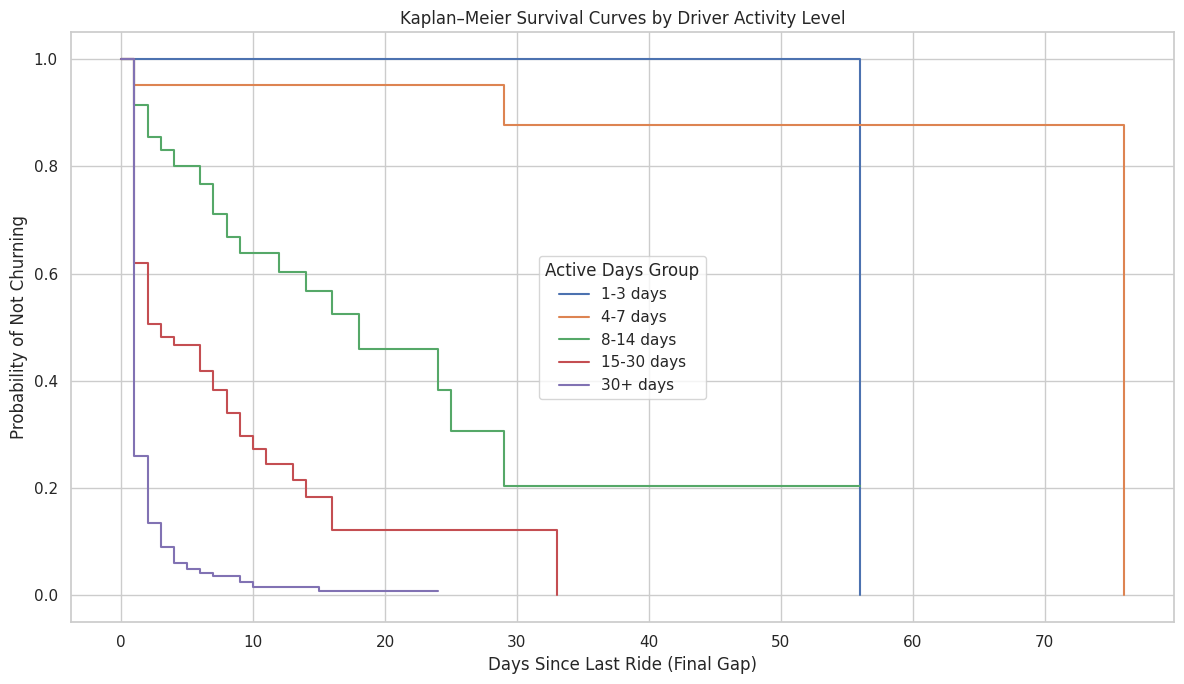

In [ ]:
from lifelines import KaplanMeierFitter

# Your dataset’s last date
data_end_date = pd.to_datetime('2016-06-27')

# Compute total active days per driver
active_days = df_drivers_dropped_off.groupby('driver_id')['date'].nunique().reset_index(name='active_days')
df_drivers_dropped_off = df_drivers_dropped_off.merge(active_days, on='driver_id', how='left')

# Bin drivers by total active days
bins = [0, 3, 7, 14, 30, 1000]
labels = ['1-3 days', '4-7 days', '8-14 days', '15-30 days', '30+ days']
df_drivers_dropped_off['activity_group'] = pd.cut(df_drivers_dropped_off['active_days'], bins=bins, labels=labels)

# Identify last ride per driver
df_drivers_dropped_off['is_last_ride'] = df_drivers_dropped_off.groupby('driver_id')['date'].transform('max') == df_drivers_dropped_off['date']

# For each driver's last ride, calculate days from last ride to dataset end
df_last = df_drivers_dropped_off[df_drivers_dropped_off['is_last_ride']].copy()
df_last['days_after_last_ride_to_end'] = (data_end_date - df_last['date']).dt.days

# Handle censoring and churn label
threshold = 7
df_last['duration'] = df_last['gap_days']
df_last['event_observed'] = 1  # assume churn by default

# If no next ride, use days until end of data as gap
df_last.loc[df_last['duration'].isna(), 'duration'] = df_last['days_after_last_ride_to_end']

# Censor drivers whose last ride is too close to data end
df_last.loc[df_last['days_after_last_ride_to_end'] > threshold, 'event_observed'] = 0

# Plot Kaplan–Meier per activity group
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

kmf = KaplanMeierFitter()

for group in labels:
    group_df = df_last[df_last['activity_group'] == group]
    if not group_df.empty:
        kmf.fit(durations=group_df['duration'], event_observed=group_df['event_observed'], label=group)
        kmf.plot_survival_function(ci_show=False)

plt.title('Kaplan–Meier Survival Curves by Driver Activity Level')
plt.xlabel('Days Since Last Ride (Final Gap)')
plt.ylabel('Probability of Not Churning')
plt.legend(title="Active Days Group")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Splitting the data to try modeling real churn event
cutoff_date = pd.to_datetime('2016-06-01')

df_drivers_dropped_off['last_ride_date'] = df_drivers_dropped_off.groupby('driver_id')['date'].transform('max')
df_past = df_drivers_dropped_off[df_drivers_dropped_off['date'] < cutoff_date].copy()
df_future = df_drivers_dropped_off[df_drivers_dropped_off['date'] >= cutoff_date].copy()

df_past['churned'] = df_past.apply(lambda x: pd.to_datetime(x['last_ride_date'])<cutoff_date, axis=1)

# Create more features for the clustering models
df_past['total_ride_distance'] = df_past.groupby('driver_id')['ride_distance'].transform('sum')
df_past['total_ride_duration'] = df_past.groupby('driver_id')['ride_duration'].transform('sum')
df_past['total_ride_prime_time'] = df_past.groupby('driver_id')['ride_prime_time'].transform('sum')

df_past['week'] = df_past['date'].dt.to_period('W').apply(lambda r: r.start_time)
df_past['month'] = df_past['date'].dt.to_period('M').apply(lambda r: r.start_time)

df_past['rides_per_week'] = df_past.groupby(['driver_id', 'week'])['driver_id'].transform('count')
df_past['rides_per_month'] = df_past.groupby(['driver_id', 'month'])['driver_id'].transform('count')

df_past['mean_weekly'] = df_past.groupby('driver_id')['rides_per_week'].transform('mean')
df_past['mean_monthly'] = df_past.groupby('driver_id')['rides_per_month'].transform('mean')

In [ ]:
df_driver_features_clustering = df_past.groupby('driver_id')[['driver_id', 'activity_group', 'churned', 'total_ride_duration', 'total_ride_prime_time', 'total_ride_distance', 'mean_weekly', 'mean_monthly']].agg('max')

cols_to_scale = ['total_ride_duration', 'total_ride_prime_time', 'total_ride_distance', 'mean_weekly', 'mean_monthly']

# We scale the data for the clustering models and one hot-encoding the groups
scaler = StandardScaler()
scaled_values = scaler.fit_transform(df_driver_features_clustering[cols_to_scale])
scaled_col_names = [f"{col}_scaled" for col in cols_to_scale]
df_driver_features_clustering[scaled_col_names] = scaled_values

recency_buckets = pd.get_dummies(df_driver_features_clustering['activity_group'])
df_driver_features_clustering = pd.concat([df_driver_features_clustering, recency_buckets], axis=1)

df_driver_features_clustering.head()

,driver_id,activity_group,churned,total_ride_duration,total_ride_prime_time,total_ride_distance,mean_weekly,mean_monthly,total_ride_duration_scaled,total_ride_prime_time_scaled,total_ride_distance_scaled,mean_weekly_scaled,mean_monthly_scaled,1-3 days,4-7 days,8-14 days,15-30 days,30+ days
driver_id,,,,,,,,,,,,,,,,,,
002be0ffdc997bd5c50703158b7c2491,002be0ffdc997bd5c50703158b7c2491,30+ days,False,29919.0,1075.0,289658.0,4.944444,17.055556,0.976700,2.353249,1.147399,0.583572,0.513260,False,False,False,False,True
007f0389f9c7b03ef97098422f902e62,007f0389f9c7b03ef97098422f902e62,8-14 days,False,5923.0,75.0,35618.0,1.571429,3.571429,-1.023593,-0.907300,-1.057301,-1.783730,-1.384002,False,False,True,False,False
011e5c5dfc5c2c92501b8b24d47509bc,011e5c5dfc5c2c92501b8b24d47509bc,8-14 days,False,14017.0,175.0,165095.0,1.909091,5.545455,-0.348882,-0.581245,0.066372,-1.546747,-1.106250,False,False,True,False,False
0152a2f305e71d26cc964f8d4411add9,0152a2f305e71d26cc964f8d4411add9,30+ days,False,18558.0,300.0,186253.0,4.700000,11.600000,0.029653,-0.173676,0.249993,0.412013,-0.254355,False,False,False,False,True
01674381af7edd264113d4e6ed55ecda,01674381af7edd264113d4e6ed55ecda,30+ days,False,18708.0,275.0,153404.0,4.636364,20.090909,0.042157,-0.255190,-0.035089,0.367350,0.940345,False,False,False,False,True


**Search for linear relationships**

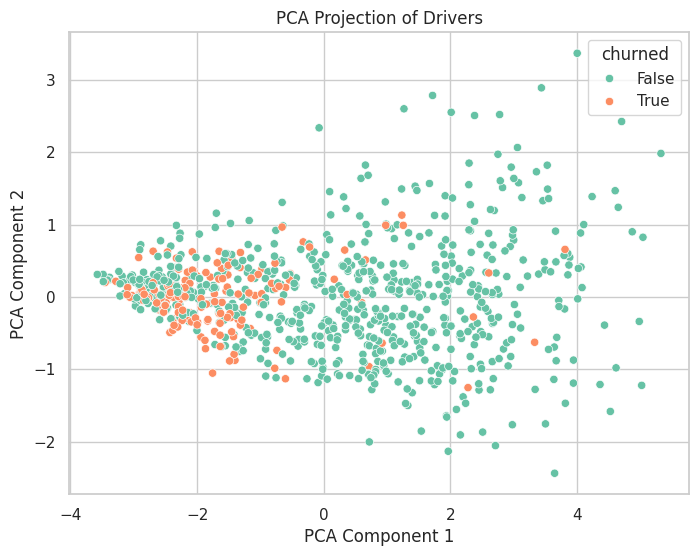

In [ ]:
from sklearn.decomposition import PCA

features_cols = ['total_ride_duration_scaled', 'total_ride_prime_time_scaled', 'total_ride_distance_scaled', 'mean_weekly_scaled', 'mean_monthly_scaled'
                , '1-3 days', '4-7 days', '8-14 days', '15-30 days', '30+ days'
                ]

# Fit PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_driver_features_clustering[features_cols])

df_driver_features_clustering['PCA1'] = X_pca[:, 0]
df_driver_features_clustering['PCA2'] = X_pca[:, 1]
# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(x='PCA1', y='PCA2', hue='churned', data=df_driver_features_clustering, palette='Set2')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Projection of Drivers')
plt.grid(True)
plt.show()

**Search for non-linear relationships**

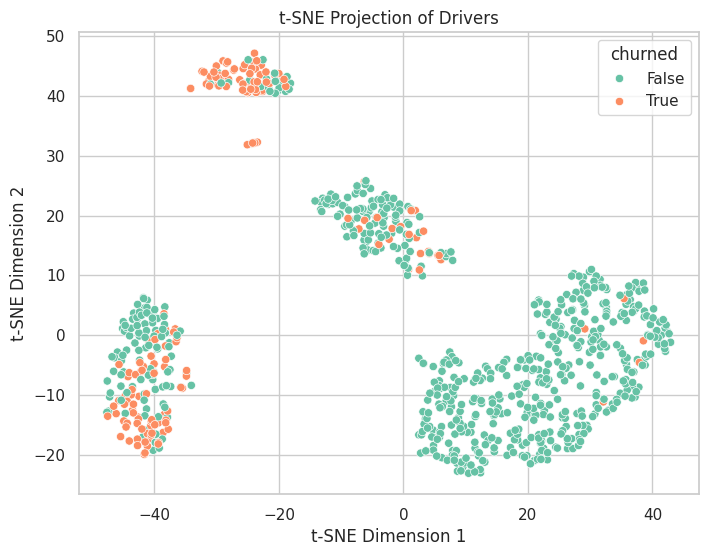

In [ ]:
from sklearn.manifold import TSNE

# Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=999)
X_tsne = tsne.fit_transform(df_driver_features_clustering[features_cols])

# Add back for plotting
df_driver_features_clustering['TSNE1'] = X_tsne[:, 0]
df_driver_features_clustering['TSNE2'] = X_tsne[:, 1]

# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='churned', data=df_driver_features_clustering, palette='Set2')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Projection of Drivers')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=999)
df_driver_features_clustering['tsne_cluster'] = kmeans.fit_predict(df_driver_features_clustering[['TSNE1', 'TSNE2']])
tsne_cluster_churn_avg = df_driver_features_clustering.groupby('tsne_cluster')['churned'].mean()
tsne_cluster_churn_avg

,churned
tsne_cluster,
0,0.423729
1,0.011261
2,0.715909
3,0.165414


In [ ]:
tsne_cluster_count = df_driver_features_clustering.groupby('tsne_cluster')['churned'].count()
tsne_cluster_count

,churned
tsne_cluster,
0,177
1,444
2,88
3,133


In [ ]:
avg_monthly_rides = round(df_driver_features_clustering["mean_monthly"].mean())

print(f'Average monthly rides is {avg_monthly_rides}')
print(f'Average ride distance is {round(df_drivers_dropped_off["ride_distance"].mean(), 1)} meters')

# Average price per mile is 1.475 (between 0.9 and 2.05 according to Gemini)
# The average  price per meter is 1.475 / 1609.34 = 0.00091
avg_ride_price = round(df_drivers_dropped_off["ride_distance"].mean() * 0.00091, 1)
print(f'Average ride price is ${avg_ride_price}')

print('\n====================\n')
churn_reduction = [0.1, 0.15, 0.2]
for cluster in range(4):
  cluster_drivers = tsne_cluster_count.iloc[cluster]
  cluster_churn_avg = round(tsne_cluster_churn_avg.iloc[cluster], 3)
  churned = round(cluster_drivers * cluster_churn_avg)

  print(f'Cluster: {cluster} Drivers: {cluster_drivers} Current churn: {cluster_churn_avg}% → {churned} churned drivers')
  print("--------------------")
  print('Reduction\tNew Churn\tΔ Retained\tExtra Rides\tRevenue')
  for reduction in churn_reduction:
    new_churn_avg = round(cluster_churn_avg * (1 - reduction), 3)
    new_churn = cluster_drivers * new_churn_avg
    delta_churn = round(churned - new_churn)
    extra_rides = round(delta_churn * avg_monthly_rides)
    revunue = round(extra_rides * avg_ride_price, 1)

    # print(f'Reduction {reduction}\t\tNew Churn {new_churn_avg}\t\tΔ Retained {delta_churn}\t\tExtra Rides {extra_rides}\t\tRevenue {revunue}')
    print(f'{reduction}\t\t{new_churn_avg}\t\t{delta_churn}\t\t{extra_rides}\t\t{revunue}')
  print("--------------------")

Avarage monthly rides is 13
Avarage ride distance is 7636.7 meters
Avarage ride price is $6.9


Cluster: 0 Drivers: 177 Current churn: 0.424% → 75 churned drivers
--------------------
Reduction	New Churn	Δ Retained	Extra Rides	Revenue
0.1		0.382		7		91		627.9
0.15		0.36		11		143		986.7
0.2		0.339		15		195		1345.5
--------------------
Cluster: 1 Drivers: 444 Current churn: 0.011% → 5 churned drivers
--------------------
Reduction	New Churn	Δ Retained	Extra Rides	Revenue
0.1		0.01		1		13		89.7
0.15		0.009		1		13		89.7
0.2		0.009		1		13		89.7
--------------------
Cluster: 2 Drivers: 88 Current churn: 0.716% → 63 churned drivers
--------------------
Reduction	New Churn	Δ Retained	Extra Rides	Revenue
0.1		0.644		6		78		538.2
0.15		0.609		9		117		807.3
0.2		0.573		13		169		1166.1
--------------------
Cluster: 3 Drivers: 133 Current churn: 0.165% → 22 churned drivers
--------------------
Reduction	New Churn	Δ Retained	Extra Rides	Revenue
0.1		0.149		2		26		179.4
0.15		0.14		3		39		269.1
0.2		

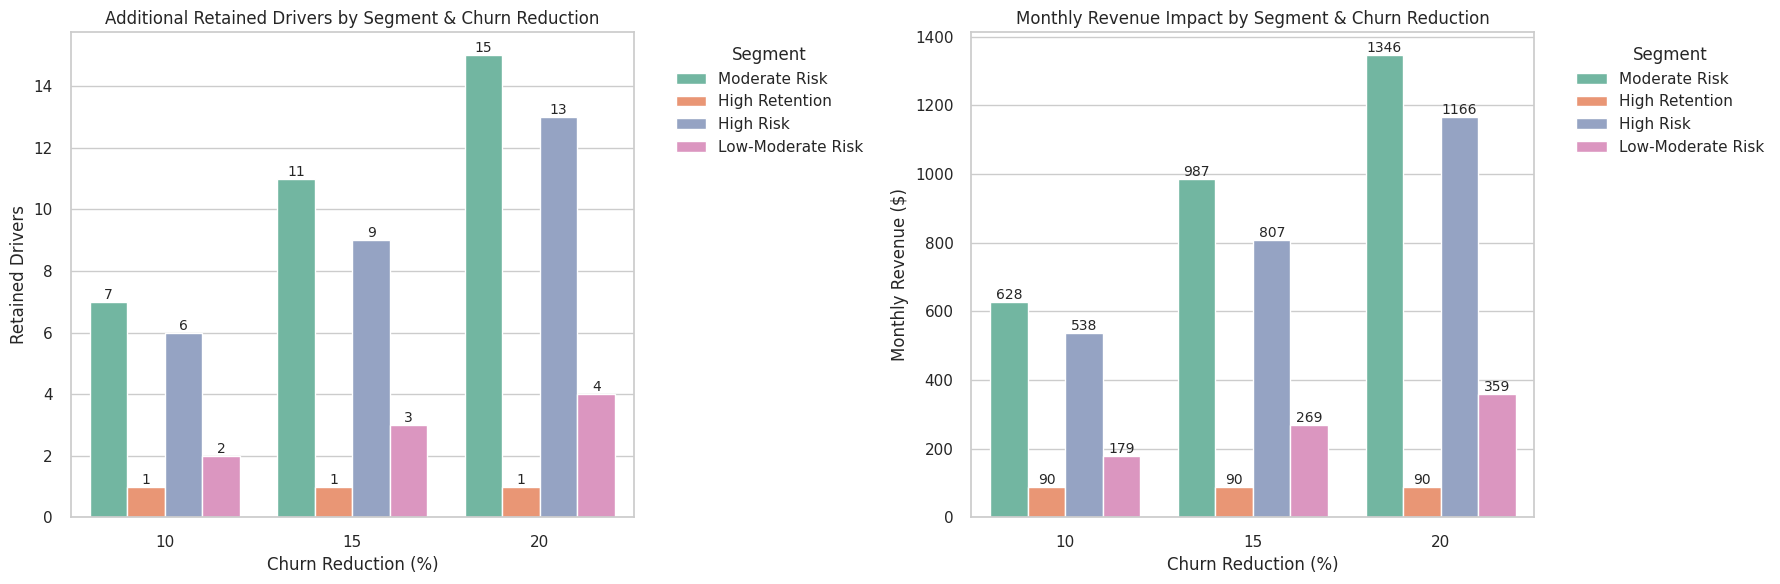

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define the data
data = [
    ("Moderate Risk", "Moderate", 10, 7, 627.90, 91),
    ("Moderate Risk", "Moderate", 15, 11, 986.70, 143),
    ("Moderate Risk", "Moderate", 20, 15, 1345.50, 195),

    ("High Retention", "Low", 10, 1, 89.70, 13),
    ("High Retention", "Low", 15, 1, 89.70, 13),
    ("High Retention", "Low", 20, 1, 89.70, 13),

    ("High Risk", "High", 10, 6, 538.20, 78),
    ("High Risk", "High", 15, 9, 807.30, 117),
    ("High Risk", "High", 20, 13, 1166.10, 169),

    ("Low-Moderate Risk", "Low-Moderate", 10, 2, 179.40, 26),
    ("Low-Moderate Risk", "Low-Moderate", 15, 3, 269.10, 39),
    ("Low-Moderate Risk", "Low-Moderate", 20, 4, 358.80, 52)
]

# Create a DataFrame
df = pd.DataFrame(data, columns=["Segment", "Risk", "ChurnReduction%", "RetainedDrivers", "MonthlyRevenue", "ExtraRides"])

# Limit palette to number of unique segments
palette = sns.color_palette("Set2", n_colors=df["Segment"].nunique())

# Set style
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Retained Drivers
bar1 = sns.barplot(data=df, x="ChurnReduction%", y="RetainedDrivers", hue="Segment", ax=axes[0], palette=palette)
axes[0].set_title("Additional Retained Drivers by Segment & Churn Reduction")
axes[0].set_ylabel("Retained Drivers")
axes[0].set_xlabel("Churn Reduction (%)")

# Add value labels to bars
for p in bar1.patches:
    height = p.get_height()
    if height > 0:
        bar1.annotate(f'{height:.0f}', (p.get_x() + p.get_width() / 2., height),
                      ha='center', va='bottom', fontsize=10)

# Plot 2: Monthly Revenue
bar2 = sns.barplot(data=df, x="ChurnReduction%", y="MonthlyRevenue", hue="Segment", ax=axes[1], palette=palette)
axes[1].set_title("Monthly Revenue Impact by Segment & Churn Reduction")
axes[1].set_ylabel("Monthly Revenue ($)")
axes[1].set_xlabel("Churn Reduction (%)")

# Add value labels to bars
for p in bar2.patches:
    height = p.get_height()
    if height > 0:
        bar2.annotate(f'{height:.0f}', (p.get_x() + p.get_width() / 2., height),
                      ha='center', va='bottom', fontsize=10)

# Adjust legend
for ax in axes:
    ax.legend(title='Segment', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

/tmp/ipython-input-9-1938907008.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title='Segment', bbox_to_anchor=(1.05, 1), loc='upper left')


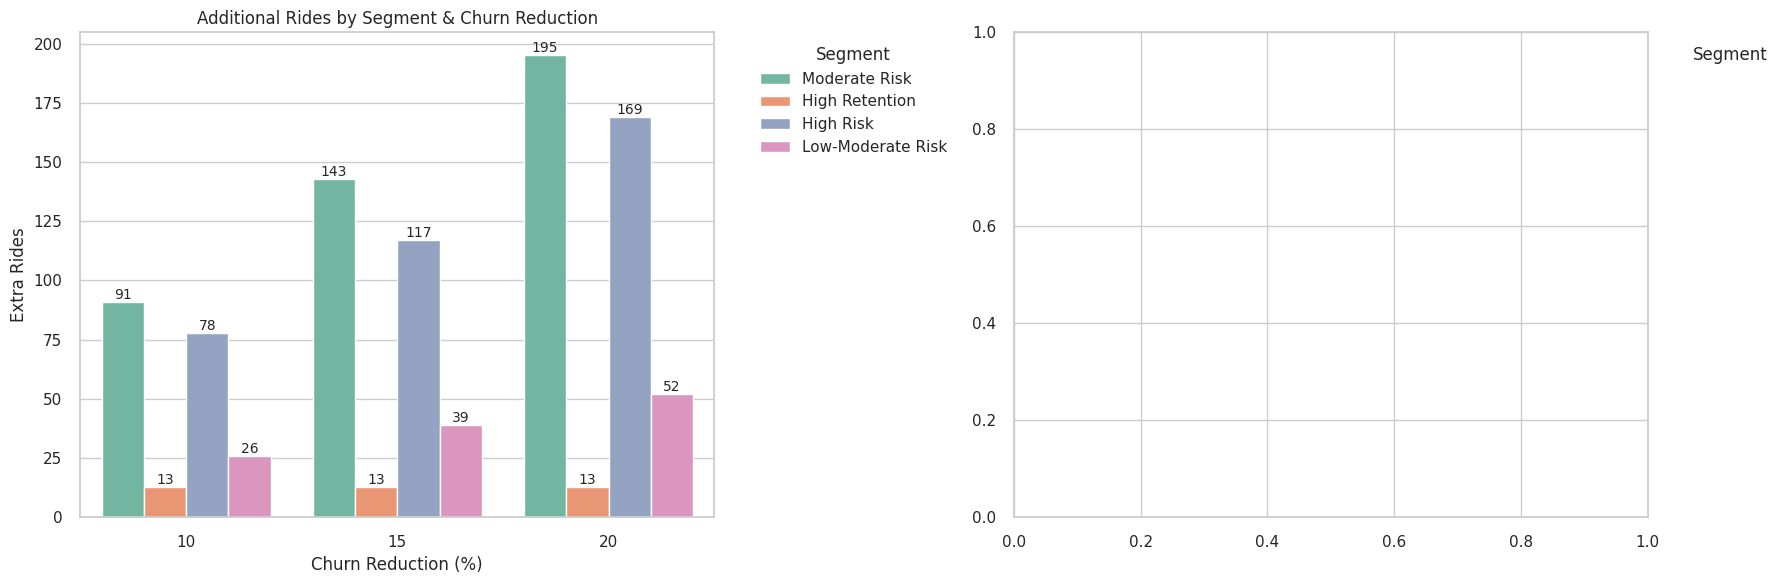

In [9]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Retained Drivers
bar1 = sns.barplot(data=df, x="ChurnReduction%", y="ExtraRides", hue="Segment", ax=axes[0], palette=palette)
axes[0].set_title("Additional Rides by Segment & Churn Reduction")
axes[0].set_ylabel("Extra Rides")
axes[0].set_xlabel("Churn Reduction (%)")

# Add value labels to bars
for p in bar1.patches:
    height = p.get_height()
    if height > 0:
        bar1.annotate(f'{height:.0f}', (p.get_x() + p.get_width() / 2., height),
                      ha='center', va='bottom', fontsize=10)

# Adjust legend
for ax in axes:
    ax.legend(title='Segment', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()